In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *
from mmr_utils import *

RCT size: 500, OS size: 1500, time elapsed: 7.44


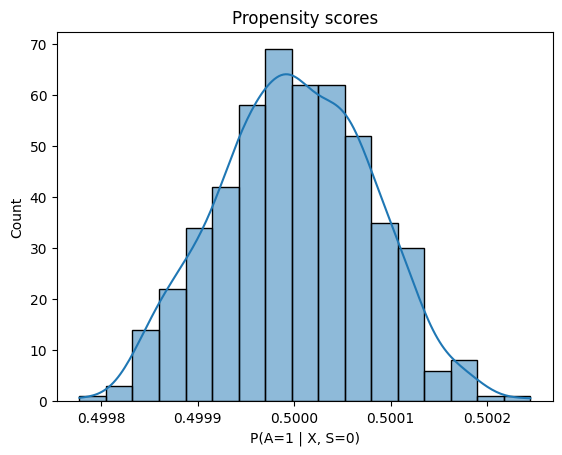

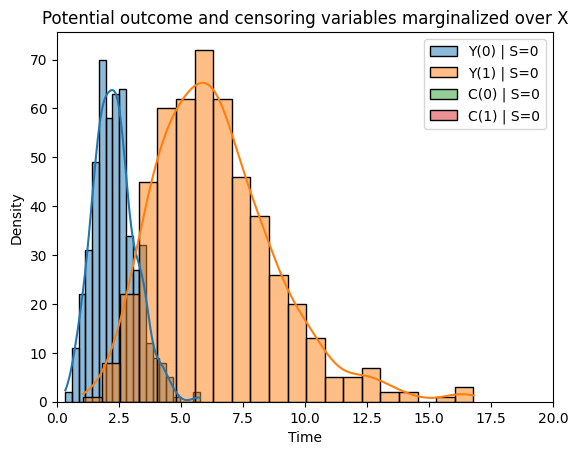

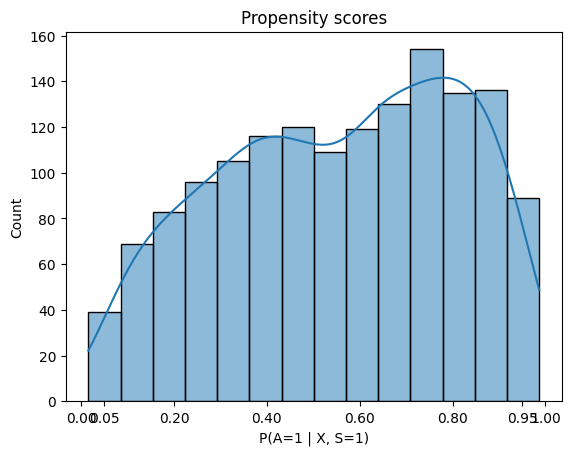

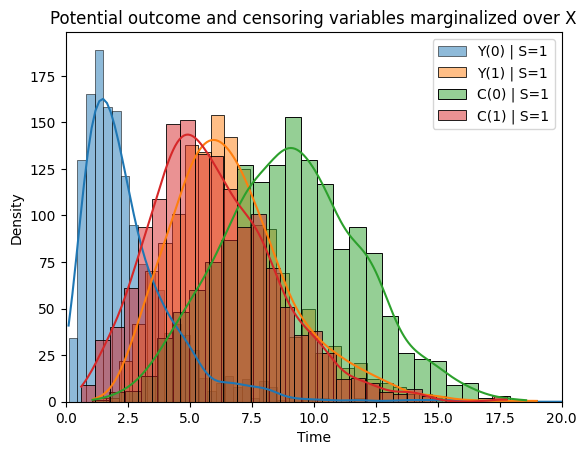

In [45]:
mmr_keys = ["IPCW", "IPW-Drop"]
CD = 10
UC = 0
jD = read_json('conditional-IC/diffPO-beta.json', CD, UC, mmr_keys)
m = 3
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = est_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

for kind, key in enumerate(mmr_keys):
    if 'Drop' in key:
        df_mmr = df_comb_drop.copy()
    else:
        df_mmr = df_combined.copy()

    if jD['crop_prop'] and ('Drop' not in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                (0.05 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

    if jD['crop_prop'] and ('Drop' in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [46]:
mmr_stats

array([[0.        , 0.44554455],
       [0.        , 0.2970297 ]])

In [12]:
df_mmr

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,P(S=1|X),"P(A=1|X,S)","mu(Y|X,S,A=0)","mu(Y|X,S,A=1)",S0_drop_ipw_est_CATE,S0_drop_ipw_est_Y1,S0_drop_ipw_est_Y0,S1_drop_ipw_est_CATE,S1_drop_ipw_est_Y1,S1_drop_ipw_est_Y0
0,1.0,-0.567941,-0.515250,0.214857,0.227763,0.157029,0.195593,-1.787096,0.704690,0.511138,...,0.735680,0.481782,1.700558,6.145555,48.266279,48.266279,-0.000000,0.000000,0.000000,-0.000000
1,1.0,-1.026184,0.109131,-0.208456,-0.316739,1.010987,-0.362502,-0.934723,0.404301,-0.779653,...,0.666758,0.595125,1.074122,5.938439,-7.954502,-0.000000,7.954502,0.000000,0.000000,-0.000000
2,1.0,0.380368,-0.849105,0.249241,-1.287520,-0.768154,-0.453446,0.306928,-0.285424,0.142485,...,0.715516,0.468691,2.506304,7.260486,54.452673,54.452673,-0.000000,0.000000,0.000000,-0.000000
3,1.0,-1.218668,0.593148,0.133649,1.812244,0.902946,-1.961559,-0.233461,1.196997,-0.804707,...,0.556798,0.522122,2.167527,7.258609,-10.234643,-0.000000,10.234643,0.000000,0.000000,-0.000000
4,1.0,-1.803654,0.924529,0.524581,-0.851453,0.132026,-0.918934,0.618007,-0.540318,-0.691057,...,0.588314,0.626169,2.874551,9.960940,38.642604,38.642604,-0.000000,0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,1.0,0.941121,2.123115,0.694793,0.423442,0.636943,0.675989,-1.694249,1.041484,-0.938493,...,0.702204,0.240726,2.773288,3.845286,0.000000,0.000000,-0.000000,-5.196844,-0.000000,5.196844
1538,1.0,0.642623,0.550389,1.969600,0.083739,-0.372430,-0.171683,0.613255,-0.484086,-0.095530,...,0.783130,0.434443,4.643540,4.603287,0.000000,0.000000,-0.000000,-10.488449,-0.000000,10.488449
1539,1.0,-0.415958,-0.221465,1.034150,-0.387135,1.170603,0.470065,-0.306652,0.650970,0.688794,...,0.667747,0.099431,2.832724,7.058219,0.000000,0.000000,-0.000000,-4.775656,-0.000000,4.775656
1540,1.0,1.030277,-0.748688,1.501842,0.073033,-1.188821,-0.172685,-1.058506,-0.340545,-0.140735,...,0.851974,0.590550,2.432389,4.084667,0.000000,0.000000,-0.000000,8.106556,8.106556,-0.000000


In [13]:
df_combined.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,"P(A=1|X,S)","mu(Y|X,S,A=0)","mu(Y|X,S,A=1)","Gb(T|X,S,A)",S0_ipcw_est_CATE,S0_ipcw_est_Y1,S0_ipcw_est_Y0,S1_ipcw_est_CATE,S1_ipcw_est_Y1,S1_ipcw_est_Y0
count,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.0,0.022455,-0.059936,0.314612,0.005112,-0.211498,0.086629,0.033127,0.270166,-0.211396,...,0.544500,2.385701,5.015481,0.878316,3.393161,5.665981,2.272820,4.728160,7.130469,2.402309
std,0.0,0.995972,0.976126,1.008896,0.980955,1.018886,0.992935,0.991363,1.005275,1.026101,...,0.227234,0.706063,1.764149,0.189659,20.309145,17.989325,7.942114,44.582385,43.839559,5.604082
min,1.0,-3.734138,-3.397932,-3.016439,-3.471806,-3.784903,-3.554848,-2.991159,-2.978410,-3.800102,...,0.020985,0.423287,0.555440,0.093368,-105.993396,0.000000,-0.000000,-138.981495,0.000000,-0.000000
25%,1.0,-0.660594,-0.709473,-0.384920,-0.666208,-0.876301,-0.596002,-0.639895,-0.447639,-0.893309,...,0.395607,1.895290,3.892664,0.796342,0.000000,0.000000,-0.000000,-3.914495,0.000000,-0.000000
50%,1.0,0.023039,-0.050245,0.275375,0.010649,-0.217877,0.111408,0.022287,0.270245,-0.217663,...,0.544223,2.341169,4.853295,0.993240,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
75%,1.0,0.700486,0.593276,1.031593,0.658954,0.495219,0.750345,0.704963,0.948084,0.476967,...,0.706444,2.827337,5.905689,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.914495
max,1.0,3.120240,3.061146,3.595643,2.735855,3.353892,4.033256,3.597160,3.538000,3.354255,...,0.995815,5.679670,17.754984,1.000000,263.082418,263.082418,105.993396,931.199340,931.199340,138.981495


In [ ]:
summary_df

In [ ]:
mu_est_baseline(df_combined.query(, target, feature, model_name='XGboost')

In [ ]:
df_combined

In [ ]:
df_combined[df_combined[]]

In [ ]:
np.sum((df_combined.S == 0) & (df_combined.A == 0))

In [ ]:
a=['1', '2', '3', '4']

In [ ]:
any(item in ['1', 'b'] for item in a)

In [ ]:
!pip install XGboost

In [ ]:
mmr_stats

In [ ]:
mis_spec = 'Fb'
cov_vals = np.zeros(CD+1)

s, a = 0,1
x = np.zeros(CD + 1)
key
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}_true']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = ty #
st_arr = sty  

func = interp1d(t_arr, st_arr, kind='linear', fill_value='extrapolate')

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
tbs_Y = RCTData.get_oracle_surv_curve(t_arr, cov_vals, f'Y{a}')

plt.figure()
plt.plot(t_arr, tbs_Y, label=f'true Y{a}', ls ='-.', alpha= 0.4)
plt.plot(t_arr, st_arr, label='est', ls='-', alpha= 0.4)
plt.plot(xnew, ynew, label='func approx', ls='--', alpha= 0.4)
plt.legend()
plt.show()

# Trange = tc.copy()

# t1 = time()
# q_arr = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y, mis_spec)
# print(f"Time: {time() - t1}")
# plt.figure()
# plt.plot(Trange, q_arr)
# plt.show()

In [ ]:
t_arr

In [ ]:
mis_spec = 'None'
cov_vals = np.random.randn(11)

s, a = 1,1
x = np.zeros(CD + 1)
key
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')

ynew = func(t_arr)   # use interpolation function returned by `interp1d`
tbs_C = OSData.get_oracle_surv_curve(t_arr, cov_vals, f'C{a}')

plt.figure()
plt.plot(t_arr, tbs_C, label=f'true C{a}', ls ='-.', alpha= 0.4)
plt.plot(t_arr, st_arr, label='est', ls='-', alpha= 0.4)
plt.plot(t_arr, ynew, label='func approx', ls='--', alpha= 0.4)
plt.legend()
plt.show()

# Trange = tc.copy()

# t1 = time()
# q_arr = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y, mis_spec)
# print(f"Time: {time() - t1}")
# plt.figure()
# plt.plot(Trange, q_arr)
# plt.show()

In [ ]:
S=0

In [ ]:
study = 'RCT' if S == 0 else 'OS'

In [ ]:
study

In [ ]:
np.array([1,1]) @ 0

In [ ]:
row = 2088

s = df_combined.loc[row, 'S']
a = df_combined.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_combined.loc[row, 'T']
Delta = df_combined.loc[row, 'Delta']

df_combined.loc[row]

In [ ]:
row = 922

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

In [ ]:
mis_spec = 'None'

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y, mis_spec)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y, mis_spec)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, mis_spec)

In [ ]:
eval_mu_(s, 1, x, Fb_Y, mis_spec)

In [ ]:
s, a = 0, 0
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
pv = np.load('results/complete-IC/samePO/CD-10/UC-0/pvals.npy')
csv = pd.read_csv('results/complete-IC/samePO/CD-10/UC-0/res_summary.csv')

np.mean(pv[2], axis=1)

In [ ]:
for s in range(2):
    for a in range(2):
        print('-----\n-----')
        #df = df_combined.query(f"S == {s} & A == {a}").copy()  # all data
        df = df_mmr.query(f"S == {s} & A == {a}").copy()       # goes into MMR (after cropping etc.)

        Ystar_No_miss = f'S{s}_Ystar{a}_Miss_None_est_CATE'
        Ystar_Fb_miss = f'S{s}_Ystar{a}_Miss_Fb_est_CATE'
        Ystar_Gb_miss = f'S{s}_Ystar{a}_Miss_Gb_est_CATE'
        
        mu_No_miss = f'S{s}_muxsa{a}_Miss_None_est_CATE'
        mu_Fb_miss = f'S{s}_muxsa{a}_Miss_Fb_est_CATE'
        mu_Gb_miss = f'S{s}_muxsa{a}_Miss_Gb_est_CATE'

        print("E[Y|S={}, A={}]: {:.2f}".format(s ,a, df[f'Y{a}'].mean()))
        print("E[Ystar_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_No_miss].mean()))
        print("E[Ystar_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Fb_miss].mean()))
        print("E[Ystar_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Gb_miss].mean()))
        print("E[mu_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_No_miss].mean()))
        print("E[mu_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Fb_miss].mean()))
        print("E[mu_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Gb_miss].mean()))

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()